# ParFlow-CLM Analysis
This notebook contains code to analyze ParFlow-CLM predictions on the national test dataset. 

In [23]:
## PRELIMINARIES ##
# general 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import xarray as xr
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
import random as rn
import pathlib
import traceback
from glob import glob
import netCDF4

from _pf_data import *

# for data
import subsettools as st
import hf_hydrodata as hf

/tmp/ipykernel_3005730/2269383872.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_statistics = pd.concat([total_statistics, single_statistics], ignore_index=True)


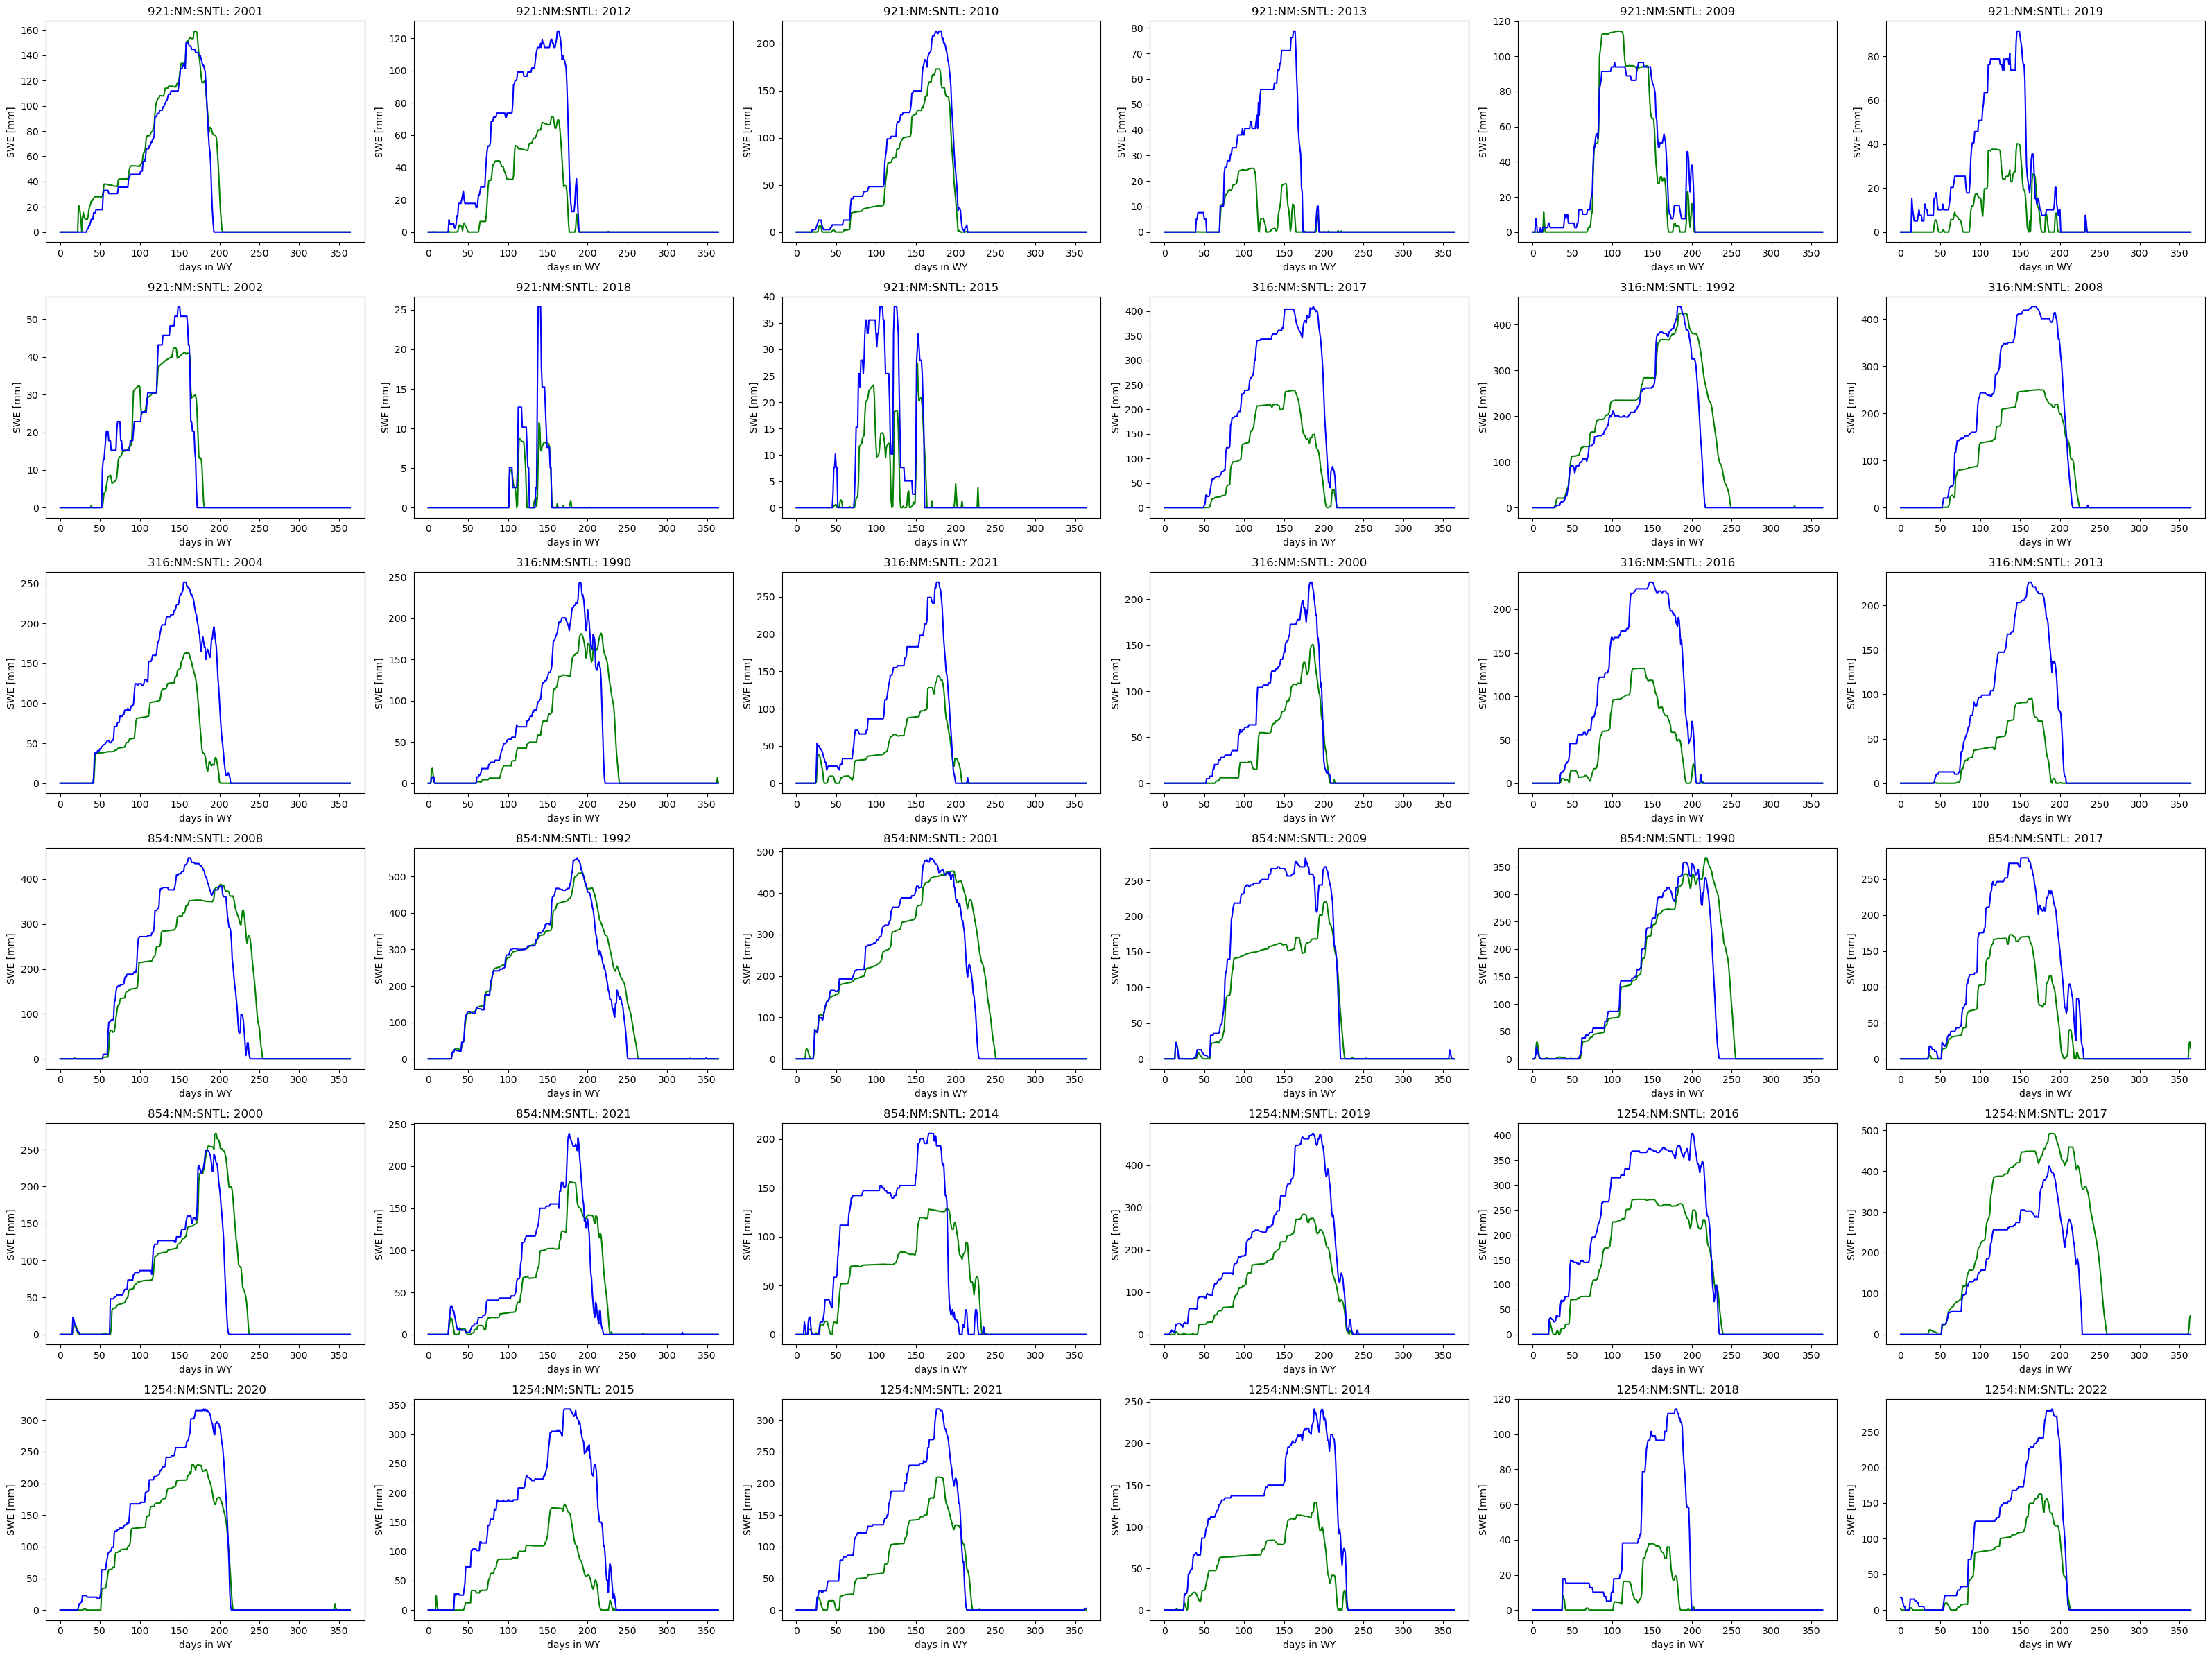

In [27]:
# GET TESTING DATA
data_test = pd.read_csv('/home/mcburns/national_lstm/national_test_years.txt', sep=' ',header=None)
data_test.columns = ['site_id',	'year',	'train']

plt.figure(figsize=(32,24))
#plt.figure(figsize=(16,10))

total_statistics = pd.DataFrame(columns=['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak','normal delta peak', 'abs delta peak', 
                                         'normal abs delta peak','delta days', 'abs delta days'])

# GET PARFLOW RESULTS FOR EACH SITE
for j in range(0, len(data_test)):
    site_id = data_test['site_id'][j]
    year = data_test['year'][j]
    start_date = str(year-1) + '-10-01'
    end_date = str(year) + '-09-30'

    try:
        swe_clm, swe_actual = prod_swe(site_id, year)
        single_statistics = analyze_results(swe_clm['swe'], swe_actual['swe'], site_id, year)
    
        #total_statistics.loc[len(total_statistics)] = single_statistics
        total_statistics = pd.concat([total_statistics, single_statistics], ignore_index=True)

        # # for single column model:
        # swe_lstm = pd.read_csv('/home/mcburns/pfclm/output/'+site_id+'/'+str(year)+'/'+site_id+'_'+str(year)+'_swe_pred.txt',sep=' ',header=None,
        #                        index_col=False) - THIS IS WRONG, SHOULD POINT TO SC MODEL
        # plt.subplot(2, 3, j+1)
        # plt.plot(swe_clm, label='CLM', c='green')
        # plt.plot(swe_lstm, label='LSTM', c='darkred')
        # plt.plot(swe_actual['swe'], label='SNOTEL', c='#203864')
        # if (j%3) == 1:
        #     plt.title(str(year)+' (average)') 
        # if (j%3) == 2:
        #     plt.title(str(year)+' (below average)')
        #     #plt.legend()
        # if (j%3) == 0:
        #     plt.title(str(year)+' (above average)') 
        #     #plt.ylabel('SWE [mm]')
        # #plt.title(f'{testing_years[y]:.0f}: RMSE: {rmse:.2f} ') 
        # plt.legend()
        # plt.ylabel('SWE [mm]')
        # plt.xlabel('days in WY')
        
        # for regional/national model:
        if (j < 36):
            plt.subplot(6, 6, j+1)
            # blue is actual, green is predicted
            plt.plot(swe_clm, label='predicted swe', c='green')
            plt.plot(swe_actual['swe'], label='actual swe', c='blue')
            plt.title(site_id + ': '+ str(year))
            plt.xlabel('days in WY')
            plt.ylabel('SWE [mm]')

    except:
        print(site_id, year)


plt.tight_layout()

In [38]:
## PRINT STATISTICS ##
#total_statistics = total_statistics.drop(666)
total_statistics = pd.read_csv('/home/mcburns/pfclm/national_statistics.txt',sep=' ',header=None)
total_statistics.columns = ['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak','normal delta peak', 'abs delta peak', 
                            'normal abs delta peak','delta days', 'abs delta days']

print('Medians:')
print(f"RMSE: {np.median(total_statistics['rmse']):.2f}")
print(f"normal RMSE: {np.median(total_statistics['normal rmse']):.2f}")
print(f"NSE: {np.median(total_statistics['nse']):.2f}")
print(f"R2: {np.median(total_statistics['r2']):.2f}")
print(f"Spearman's rho: {np.median(total_statistics['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.median(total_statistics['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.median(total_statistics['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.median(total_statistics['abs delta peak']):.2f}")
print(f"normal absolute delta peak SWE: {np.median(total_statistics['normal abs delta peak']):.2f}")
print(f"delta days: {np.median(total_statistics['delta days']):.2f}")
print(f"absolute delta days: {np.median(total_statistics['abs delta days']):.2f}")

print('\nMeans:')
print(f"RMSE: {np.mean(total_statistics['rmse']):.2f}")
print(f"normal RMSE: {np.mean(total_statistics['normal rmse']):.2f}")
print(f"NSE: {np.mean(total_statistics['nse']):.2f}")
print(f"R2: {np.mean(total_statistics['r2']):.2f}")
print(f"Spearman's rho: {np.mean(total_statistics['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.mean(total_statistics['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.mean(total_statistics['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.mean(total_statistics['abs delta peak']):.2f}")
print(f"absolute normal delta peak SWE: {np.mean(total_statistics['normal abs delta peak']):.2f}")
print(f"delta days: {np.mean(total_statistics['delta days']):.2f}")
print(f"absolute delta days: {np.mean(total_statistics['abs delta days']):.2f}")

# standard deviations of normal values
print('\nStandard deviations:')
print(f"normal RMSE: {np.std(total_statistics['normal rmse']):.2f}")
print(f"NSE: {np.std(total_statistics['nse']):.2f}")
print(f"normal delta peak SWE: {np.std(total_statistics['normal delta peak']):.2f}")
print(f"normal absolute delta peak SWE: {np.std(total_statistics['normal abs delta peak']):.2f}")
print(f"absolute delta days: {np.std(total_statistics['abs delta days']):.2f}")

Medians:
RMSE: 74.21
normal RMSE: 0.23
NSE: 0.64
R2: 0.64
Spearman's rho: 0.93
delta peak SWE: -100.26
normal delta peak SWE: -0.31
absolute delta peak SWE: 122.37
normal absolute delta peak SWE: 0.36
delta days: -3.00
absolute delta days: 13.00

Means:
RMSE: 110.83
normal RMSE: 0.26
NSE: -1.02
R2: -1.02
Spearman's rho: 0.87
delta peak SWE: -90.50
normal delta peak SWE: -0.32
absolute delta peak SWE: 157.57
absolute normal delta peak SWE: 0.41
delta days: 1.09
absolute delta days: 24.20

Standard deviations:
normal RMSE: 0.15
NSE: 33.40
normal delta peak SWE: 0.40
normal absolute delta peak SWE: 0.31
absolute delta days: 32.42


666
-970.4518270065762


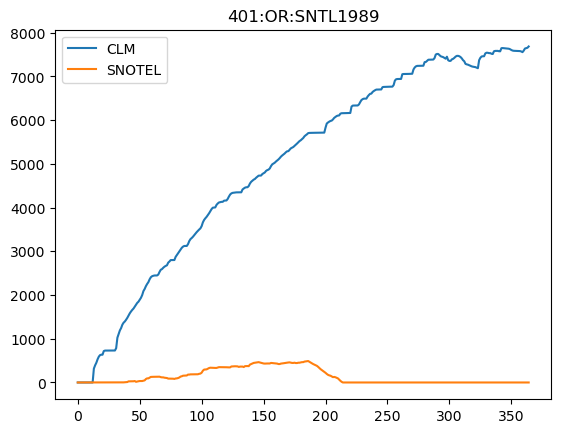

In [36]:
# figure out sites where the model is really wrong
ind = total_statistics['nse'].idxmin()
print(ind)
print(min(total_statistics['nse']))

site_id = data_test['site_id'][ind]
year = data_test['year'][ind]

swe_clm, swe_actual = prod_swe(site_id, year)

plt.plot(swe_clm['swe'], label='CLM')
plt.plot(swe_actual['swe'], label='SNOTEL')
plt.title(site_id + str(year))
plt.legend()

In [29]:
total_statistics.to_csv('/home/mcburns/pfclm/national_statistics.txt',sep=' ',header=None, index=False, index_label=False)

In [ ]:
# could add more thorough analysis (i.e. latitude, location, etc)